In [1]:
import sys
sys.path.append('CONFIG_files/')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import shutil

from matplotlib import pyplot as plt
from tabulate import tabulate

import os, shutil, time, pdb, random
import scipy.stats as stats 
import scipy

from math import pi
from datetime import datetime
from collections import OrderedDict
import pickle

import torch
from torch.utils.data import TensorDataset, DataLoader

from importlib import reload
from models import *
from utils import *
from runmanager import *
from experiment import *
from plot_utils import *
from preprocessing_utils import *
from analysis_seasonal import * 

from sklearn.metrics import mean_squared_error as mse

import matplotlib
matplotlib.rc_file_defaults()
%matplotlib inline

# import CONFIG_SUSHIWAT_BGMM_23_JUNE_2023 as C
import CONFIG as C

pd.options.display.max_columns = None

np.random.seed(4)

%load_ext autoreload
%autoreload 2

device = C.device

C.REGION, C.RUN_NAME, C.split_by

('COMBINED', 'COMBINED_RECURRENT_2_DEC_2023_EXP_2', 'station')

### Import data

In [2]:
data = DataPreprocessing(train_path=C.TRAIN_PATH, start=C.start, end=C.end, 
                add_yesterday = False, 
                basin_filter = None, 
                split_bias_corrected_only = False, 
                filter_incomplete_years = False, 
                include_non_bc_stations = True, 
                split_by = C.split_by)

/users/marron31/repos/upper-indus-prec-bc/preprocessing_utils.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[series][df[series] < 0] = 0


### Split data into held out sets for K-fold cross validation

In [3]:
if C.SORT_BY_ELEVATION:
    data.split_stations(sort_by_elev = True)
else:
    data.split_stations(sort_by_elev = False)
    
print(C.SORT_BY_ELEVATION)

False


### Prepare data

In [ ]:
if C.ADD_PREVIOUS_DAY:
    C.predictors.append('obs_yesterday')

data.input_data(C.predictors, C.predictand, sort_by_quantile=C.sort_by_quantile)

print(C.ADD_PREVIOUS_DAY)
print(C.sort_by_quantile)

## Multi-Run: Train model with different hyperparameters

### Model run

In [ ]:
experiment_label = C.RUN_NAME
experiment_label, C.K_FOLD

In [ ]:
load_run = None

,run,epoch,loss,valid_loss,test_loss,decision_loss,epoch duration,run duration,lr,batch_size,likelihood_fn,dropout_rate,random_noise,k,model_arch
0,1,1,3.035277,4.166486,3.869365,4.166486,16.664939,16.664949,0.001,32,gaussian,0,0,0,"(MLP, [50, 50])"
1,1,2,2.588123,3.652568,3.542632,3.652568,16.035712,32.718657,0.001,32,gaussian,0,0,0,"(MLP, [50, 50])"
2,1,3,2.547319,3.942407,3.719121,3.942407,16.161398,48.899365,0.001,32,gaussian,0,0,0,"(MLP, [50, 50])"
3,1,4,2.550579,3.668114,3.561984,3.668114,16.182381,65.100014,0.001,32,gaussian,0,0,0,"(MLP, [50, 50])"
4,1,5,2.569315,3.652273,3.557734,3.652273,16.238965,81.354405,0.001,32,gaussian,0,0,0,"(MLP, [50, 50])"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,8,6,1.241296,1.152631,1.304085,1.152631,18.581110,112.786939,0.001,32,bernoulli_halfnormal,0,0,0,"(MLP, [50, 50])"
76,8,7,1.229003,1.140785,1.314341,1.140785,18.663235,131.473986,0.001,32,bernoulli_halfnormal,0,0,0,"(MLP, [50, 50])"
77,8,8,1.230008,1.139755,1.303873,1.139755,18.582851,150.088901,0.001,32,bernoulli_halfnormal,0,0,0,"(MLP, [50, 50])"
78,8,9,1.232803,1.145598,1.313998,1.145598,18.269347,168.380692,0.001,32,bernoulli_halfnormal,0,0,0,"(MLP, [50, 50])"


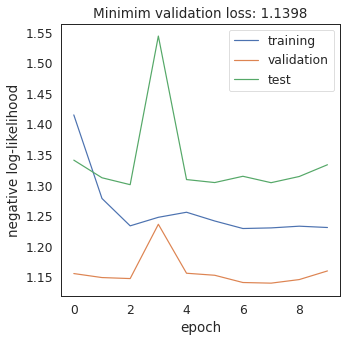

MLP_[50, 50]_bernoulli_halfnormal_B=32_D=0_RN=0


In [50]:
if load_run == None:
    src = 'CONFIG.py'
    dst = f'CONFIG_files/CONFIG_{experiment_label}.py'
    shutil.copy(src, dst)

st_test, predictions, importances = multirun(data, C.predictors, C.params, C.epochs, 
                                split_by = 'station', 
                                draw_samples=False, sequential_samples = True, n_samples=1, 
                                load_run = load_run, #None, 
                                experiment_label = experiment_label, 
                                feature_attribution = False, 
                                show_loss_plot=True)

In [14]:
# table_of_predictions_ks_test(predictions, C.seasons, columns, sample_cols, add_cols)

In [17]:
# table_of_predictions_for_metric(predictions, C.seasons, columns, C.n_samples, sample_cols, add_cols, metric = 'smape', prefix='smape')

In [18]:
# table_of_predictions_for_metric(predictions, C.seasons, columns, C.n_samples, sample_cols, add_cols, metric = 'edd', prefix='edd')

In [19]:
# table_of_predictions_for_metric(predictions, C.seasons, columns, C.n_samples, sample_cols, add_cols, metric = 'ae', prefix='ae')

In [ ]:
a = pd.read_csv('results.csv')

b = a.groupby(['k','run']).agg({'valid_loss': 'min', 
                                 'model_arch': 'first', 
                                 'likelihood_fn': 'first',
                                 'lr':'first',
                                 'batch_size':'first',
                                 'dropout_rate':'first',
                               })

c = b.groupby(['run']).agg({'valid_loss': 'mean', 
                        'model_arch': 'first', 
                        'likelihood_fn': 'first',
                        'lr':'first',
                        'batch_size':'first',
                        'dropout_rate':'first',
                         }
                   ).sort_values('valid_loss').reset_index()

c.groupby(['model_arch',
           'likelihood_fn',
           'lr',
           'batch_size',
           'dropout_rate',
           ]).agg({'valid_loss': 'mean'}
                   ).sort_values('valid_loss').reset_index()